# Example ML to land cover classification
Example of model benchmarking and implementation using Rußwurm & Korner (2017)'s sequence data approach for land cover classification using MODIS (MOD13Q1) satellite data time series and ESA-CCI (reference land cover maps, 1992-2016)

Rußwurm M., Körner M. (2017). Temporal Vegetation Modelling using Long Short-Term Memory Networks
for Crop Identification from Medium-Resolution Multi-Spectral Satellite Images. In Proceedings of the
IEEE Conference on Computer Vision and Pattern Recognition (CVPR) Workshops, 2017.

In [4]:
import os

In [5]:
os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=cpu'

In [9]:
import time
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils import np_utils

In [12]:
#functions
def onehot(labels):
    Uniques,Index  = np.unique(labels,return_inverse=True)
    return np_utils.to_categorical(Index,len(Uniques))

def inverse_onehot(matrix):
    labels =[]
    for row in matrix:
        labels.append(np.argmax(row,axis=0))
    return labels   

In [10]:
#load pandas data (train and validation sets) - to be stored locally. Dataset available online in the repository
in_dir = "/home/acocac/post/tmp/"
df_train = pd.read_csv(in_dir + "traindata_2classes.csv", sep=',')

In [13]:
##input data preparation
#pandas to 3d array
train_dataset = np.array(list(df_train.groupby('Mid').apply(pd.DataFrame.as_matrix)))
validation_dataset = np.array(list(df_validation.groupby('Mid').apply(pd.DataFrame.as_matrix)))

#settings
n_classes = 2
target = ['red','blue','nir','mir','fyear'] #variables by doy

index_features = map(lambda col: df_train.columns.get_loc(col), target)
index_labels = df_train.columns.get_loc('label')

#data
X = train_dataset[:,:,index_features]
Y = train_dataset[:,:,index_labels]
Y = Y.mean(axis=1, dtype='int16')

In [14]:
LR = {'package':'sklearn',"name": 'Logistic Regression', "conf": LogisticRegression(), "results" : [], "time": []}
DT = {'package':'sklearn',"name": 'Decision Tree', "conf": DecisionTreeClassifier(max_depth=10), "results" : [],"time": []}
RF1 = {'package':'sklearn',"name": 'Simple Random Forest', "conf": RandomForestClassifier(n_jobs=-1, max_depth=10), "results" : [],"time": []}
RF2 = {'package':'sklearn',"name": 'Complex Random Forest', "conf": RandomForestClassifier(n_jobs=-1, n_estimators=50), "results" : [],"time": []}
GB = {'package':'sklearn',"name": 'Gradient Boosting', "conf": GradientBoostingClassifier(), "results" : [],"time": []}
SVM = {'package':'sklearn',"name": 'Support Vector Machines', "conf": SVC(), "results" : [],"time": []}
FFNN1 = {'package':'keras',"name": 'Simple ANN', "results" : [],"time": []}
FFNN2 = {'package':'keras',"name": 'Complex ANN', "results" : [],"time": []}
LSTMRNN = {'package':'keras',"name": 'Long Short Term Memory (LSTM)', "results" : [],"time": []}

models = [LR, DT, RF1, RF2, GB, SVM, FFNN1, FFNN2, LSTMRNN]

In [15]:
#fix random seed for reproducibility
seed = 7
np.random.seed(seed)

#define k-fold cross validation
folds = 2
kfold = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed) #ensure each fold is different and each sample is seen only once.

#LSTM and FFNN model settings
batch_size = 100 
n_epoch = 120 

#empty df
res = pd.DataFrame(columns=['acc', 'acc_std', 'time', 'time_std'])

for train, test in kfold.split(X, Y): 
    
    #input data LSTM
    train_data = X[train]
    test_data = X[test]

    #input data shallow
    train_data_trans = np.reshape(train_data, (train_data.shape[0], train_data.shape[1]*train_data.shape[2])).astype('float32')
    test_data_trans = np.reshape(test_data, (test_data.shape[0], test_data.shape[1]*test_data.shape[2])).astype('float32')
    
    for m in models:
        if m['package'] == 'keras':
            model = Sequential()
            if m['name'] == 'Simple ANN':  
                model.add(Dense(50, input_shape=(train_data_trans.shape[1],), activation='relu'))
                model.add(Dense(n_classes, activation='softmax'))
            elif m['name'] == 'Complex ANN':  
                model.add(Dense(50, input_shape=(train_data_trans.shape[1],), activation='relu'))
                model.add(Dropout(0.5))
                model.add(Dense(50, activation='relu'))
                model.add(Dropout(0.5))
                model.add(Dense(n_classes, activation='softmax'))
            elif m['name'] == 'Long Short Term Memory (LSTM)':  
                model.add(LSTM(50, input_shape=(train_data.shape[1], train_data.shape[2])))
                model.add(Dropout(0.5))
                model.add(Dense(50, activation='relu'))
                model.add(Dropout(0.5))
                model.add(Dense(n_classes, activation='softmax'))

            model.compile(loss='categorical_crossentropy', optimizer=RMSprop(lr=0.01), metrics=['acc'])

            if m['name'] != 'Long Short Term Memory (LSTM)':  
                start = time.time()
                model.fit(train_data_trans, onehot(Y[train]), batch_size=batch_size, nb_epoch=n_epoch, verbose=0)
                elapsed = time.time() - start
                m['time'].append(elapsed)
                res.loc[m['name'], 'time'] = np.mean(m['time'])
                res.loc[m['name'], 'time_std'] = np.std(m['time'])
                # evaluate the model
                scores = model.evaluate(test_data_trans, onehot(Y[test]), verbose=0, batch_size=1000)
                
            elif m['name'] == 'Long Short Term Memory (LSTM)': 
                start = time.time()
                model.fit(train_data, onehot(Y[train]), batch_size=batch_size, nb_epoch=n_epoch, verbose=0)
                elapsed = time.time() - start
                m['time'].append(elapsed)
                res.loc[m['name'], 'time'] = np.mean(m['time'])
                res.loc[m['name'], 'time_std'] = np.std(m['time'])
                # evaluate the model
                scores = model.evaluate(test_data, onehot(Y[test]), verbose=0, batch_size=1000)

            m['results'].append(scores[1] * 100)
            res.loc[m['name'], 'acc'] = np.mean(m['results'])
            res.loc[m['name'], 'acc_std'] = np.std(m['results'])
            res.loc[m['name'], 'parameters'] = model.count_params()
            
            del start, elapsed, model
            
        elif m['package'] == 'sklearn':
            model = m['conf']

            start = time.time()
            model.fit(train_data_trans, Y[train])
            elapsed = time.time() - start
            m['time'].append(elapsed)
            res.loc[m['name'], 'time'] = np.mean(m['time'])
            res.loc[m['name'], 'time_std'] = np.std(m['time'])

            y_pred = model.predict(test_data_trans)
            m['results'].append(np.mean(Y[test] == y_pred) * 100)
            res.loc[m['name'], 'acc'] = np.mean(m['results'])
            res.loc[m['name'], 'acc_std'] = np.std(m['results'])

            #parameters
            if isinstance(m['conf'], sklearn.linear_model.logistic.LogisticRegression):
                res.loc[m['name'],'parameters'] = model.coef_.shape[0] * model.coef_.shape[1] 
            elif isinstance(m['conf'], sklearn.tree.tree.DecisionTreeClassifier):
                res.loc[m['name'],'parameters'] = model.tree_.node_count 
            elif isinstance(m['conf'], sklearn.ensemble.forest.RandomForestClassifier):
                nodes = 0
                for tree in model.estimators_:
                    nodes += tree.tree_.node_count
                if m['name'] == 'Simple Random Forest':
                    res.loc[m['name'], 'parameters'] = nodes
                if m['name'] == 'Complex Random Forest':
                    res.loc[m['name'], 'parameters'] = nodes
            elif isinstance(m['conf'], sklearn.ensemble.gradient_boosting.GradientBoostingClassifier):
                for temp in model.estimators_:
                    for tree in temp:
                        nodes += tree.tree_.node_count 
                res.loc[m['name'], 'parameters'] = nodes
            elif isinstance(m['conf'], sklearn.svm.classes.SVC):
                res.loc[m['name'], 'parameters'] = model.support_vectors_.shape[0]

            del y_pred, start, elapsed, model

In [20]:
res

,acc,acc_std,time,time_std,parameters
Logistic Regression,88.596,0.127202,0.0261594,0.00184453,5.0
Decision Tree,91.4378,0.119082,0.0586134,0.00866854,733.0
Simple Random Forest,92.7268,0.222097,0.175117,0.00266147,5978.0
Complex Random Forest,93.2128,0.00795737,0.454088,0.066051,74052.0
Gradient Boosting,92.6156,0.168552,0.682098,0.00646389,75534.0
Support Vector Machines,88.5342,0.132262,3.82494,0.167151,4490.0
Simple ANN,92.4138,0.345637,8.42906,0.291829,402.0
Complex ANN,91.6725,0.000343444,21.4754,0.352332,2952.0
Long Short Term Memory (LSTM),92.3479,0.0573436,63.556,0.269691,13852.0


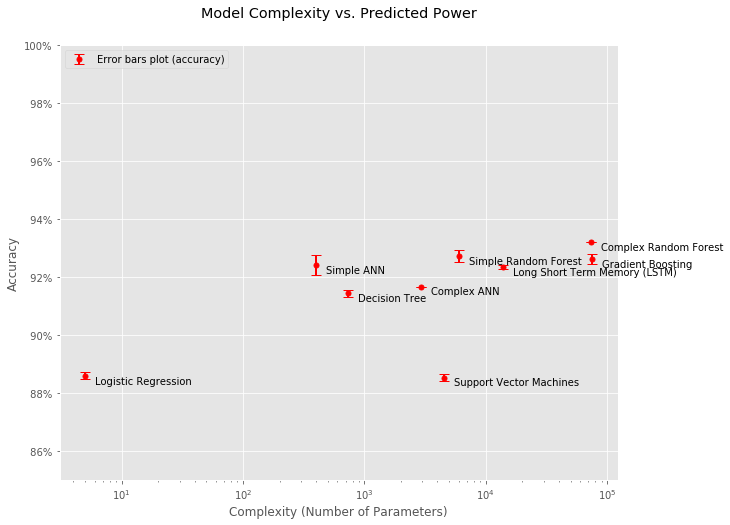

In [18]:
#PLOT Model Benchmark
import matplotlib
import matplotlib.pyplot as pl
%matplotlib inline

pl.style.use('ggplot')

fig, ax = pl.subplots(figsize=(10,8))
pl.errorbar(res.parameters,res.acc,yerr=res.acc_std, marker='o',
            markersize=5,  lw=0,  label="Error bars plot (accuracy)", capsize=5, ls='none', color='red', 
            elinewidth=2)

pl.ylim([85, 100])
pl.xlabel('Complexity (Number of Parameters)')
pl.ylabel('Accuracy')
ax.set_xscale('log')


vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x) for x in vals])
pl.title('Model Complexity vs. Predicted Power', y=1.05)
ax.legend(loc='upper left', numpoints=1, fancybox=True)

for label, x, y in zip(res.index, res.parameters, res.acc):
    pl.annotate(
        label, 
        xy = (x, y), xytext = (10, -10),
        textcoords = 'offset points', ha = 'left', va = 'bottom')